<a href="https://colab.research.google.com/github/R3gm/Colab-resources/blob/main/Interpreting_Stable_Diffusion_Using_Cross_Attention__DAAM_Diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion attentive attribution maps for interpreting Stable Diffusion

| Description | Link |
| ----------- | ---- |
| 🎉 Repository | [![GitHub Repository](https://img.shields.io/github/stars/castorini/daam?style=social)](https://github.com/castorini/daam) |
| Original Colab | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1miGauqa07uHnDoe81NmbmtTtnupmlipv?usp=sharing) |
| 🚀 Online inference | [![Hugging Face Spaces](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/tetrisd/Diffusion-Attentive-Attribution-Maps) |
| 🔥 Discover More Colab Notebooks | [![GitHub Repository](https://img.shields.io/badge/GitHub-Repository-black?style=flat-square&logo=github)](https://github.com/R3gm/Colab-resources/) |


## Setup

In [1]:
!pip install daam==0.0.14 transformers==4.27.4 diffusers==0.14.0
!pip install accelerate  # this is to reduce CPU model load overhead

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!nvidia-smi

Mon May 29 23:01:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Using DAAM as a Library

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

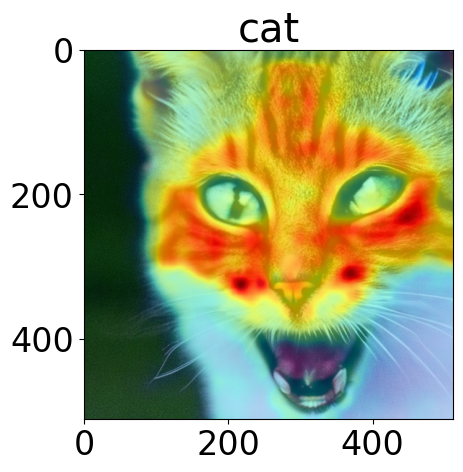

In [2]:
from daam import trace, set_seed
from diffusers import StableDiffusionPipeline
from matplotlib import pyplot as plt
import torch


model_id = 'stabilityai/stable-diffusion-2-base'
device = 'cuda'

pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe = pipe.to(device)

prompt = 'A cat runs across the field'
gen = set_seed(0)  # for reproducibility

with torch.cuda.amp.autocast(dtype=torch.float16), torch.no_grad():
    with trace(pipe) as tc:
        out = pipe(prompt, num_inference_steps=30, generator=gen)
        heat_map = tc.compute_global_heat_map()
        heat_map = heat_map.compute_word_heat_map('cat') # search cat
        heat_map.plot_overlay(out.images[0])
        plt.show()

## Global Word Attribution Maps

In [3]:
from diffusers import StableDiffusionPipeline
import daam

In [4]:
model = StableDiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-2-base')
model = model.to('cuda')

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

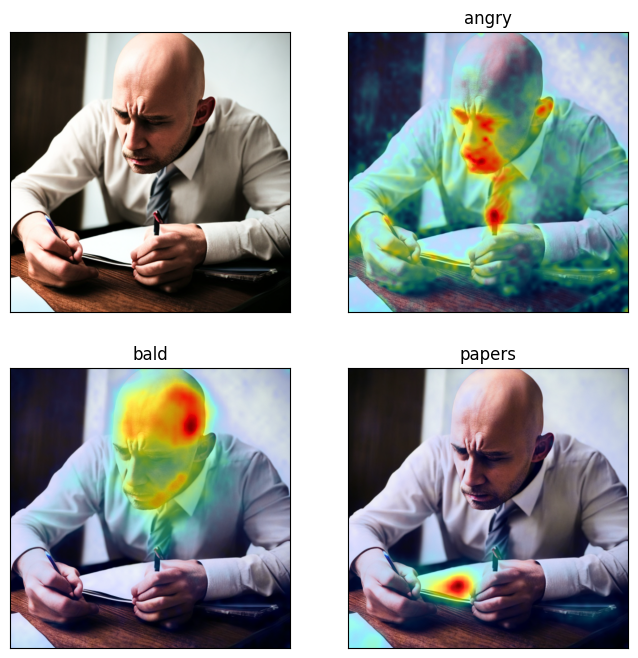

In [8]:
from matplotlib import pyplot as plt
import numpy as np

def make_im_subplots(*args):
  fig, ax = plt.subplots(*args)

  for ax_ in ax.flatten():
    ax_.set_xticks([])
    ax_.set_yticks([])
  
  return fig, ax

prompt = 'An angry, bald man writing papers'

# Trace through generation
with daam.trace(model) as trc:
  output_image = model(prompt, num_inference_steps=20).images[0]
  global_heat_map = trc.compute_global_heat_map()

angry_heat_map = global_heat_map.compute_word_heat_map('angry')
bald_heat_map = global_heat_map.compute_word_heat_map('bald')
papers_heat_map = global_heat_map.compute_word_heat_map('papers')

plt.rcParams['figure.figsize'] = (8, 8)
fig, ax = make_im_subplots(2, 2)

# Original image
ax[0, 0].imshow(output_image)

# Angry heat map
angry_heat_map.plot_overlay(output_image, ax=ax[0, 1])

# Bald heat map
bald_heat_map.plot_overlay(output_image, ax=ax[1, 0])

# Papers heat map
papers_heat_map.plot_overlay(output_image, ax=ax[1, 1])

plt.show()

## Per-Head Attribution Maps

  0%|          | 0/20 [00:00<?, ?it/s]

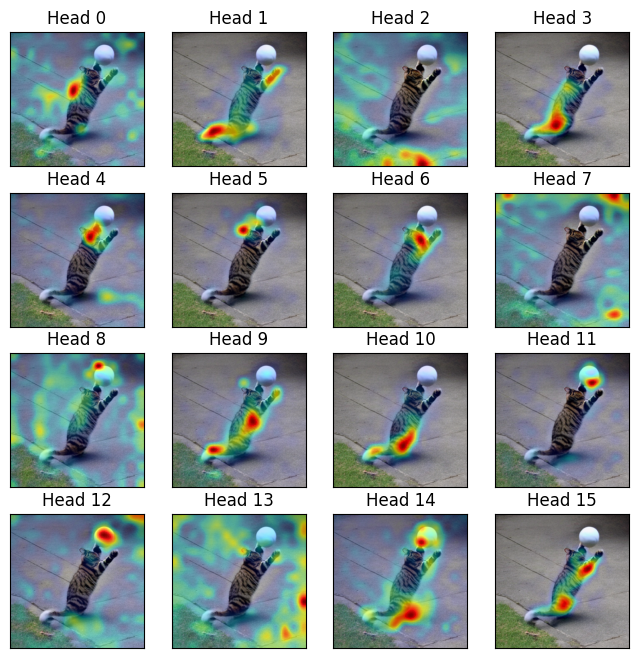

In [11]:
prompt = 'A cute cat pouncing on a ball'
fig, ax = make_im_subplots(4, 4)

# Trace through generation
with daam.trace(model) as trc:
  output_image = model(prompt, num_inference_steps=20).images[0]

  for head_idx in range(16):
    ax_ = ax[head_idx // 4, head_idx % 4]
    global_heat_map = trc.compute_global_heat_map(head_idx=head_idx, layer_idx=2)
    angry_heat_map = global_heat_map.compute_word_heat_map('cat')
    angry_heat_map.plot_overlay(output_image, ax=ax_)
    ax_.set_title(f'Head {head_idx}')
    
plt.show()

## Adjectival Entanglement

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

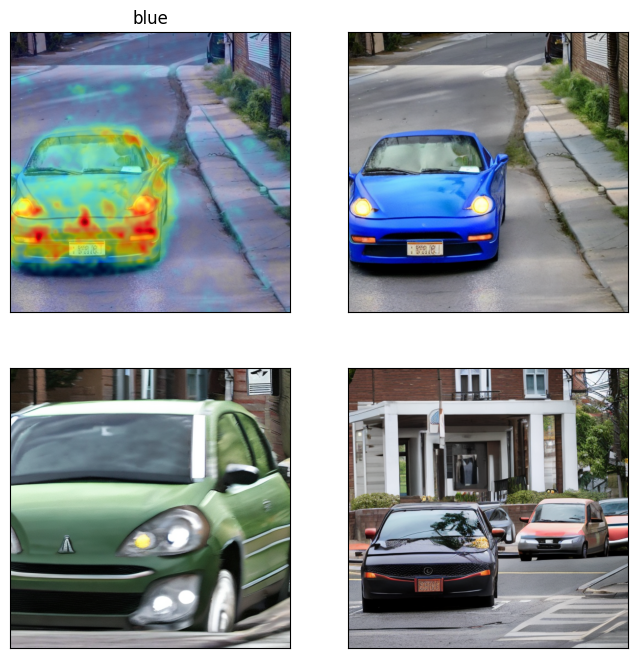

In [12]:
# Trace through generation
import time
import torch
import random
from matplotlib import pyplot as plt
import numpy as np

def set_seed(seed):
  gen = torch.Generator(device='cuda')
  random.seed(seed)
  np.random.seed(seed)
  torch.cuda.manual_seed(seed)
  torch.manual_seed(seed)

  return gen.manual_seed(s)

s = int(time.time())
gen = set_seed(s)

with daam.trace(model, save_heads=True) as trc:
  blue_image = model('a blue car driving down the street', num_inference_steps=20, generator=gen).images[0]
  blue_map = trc.compute_global_heat_map().compute_word_heat_map('blue')

gen = set_seed(s)

with daam.trace(model, load_heads=True) as trc:
  green_image = model('a green car driving down the street', num_inference_steps=20, generator=gen).images[0]
  green_map = trc.compute_global_heat_map().compute_word_heat_map('green')

gen = set_seed(s)

with daam.trace(model, load_heads=True) as trc:
  red_image = model('a red car driving down the street', num_inference_steps=20, generator=gen).images[0]
  red_map = trc.compute_global_heat_map().compute_word_heat_map('red')

plt.rcParams['figure.figsize'] = (8, 8)
fig, ax = make_im_subplots(2, 2)

# Original images
ax[0, 1].imshow(blue_image)
ax[1, 0].imshow(green_image)
ax[1, 1].imshow(red_image)

# Heat map
blue_map.plot_overlay(blue_image, ax=ax[0, 0])

plt.show()

## Cohyponym Entanglement

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

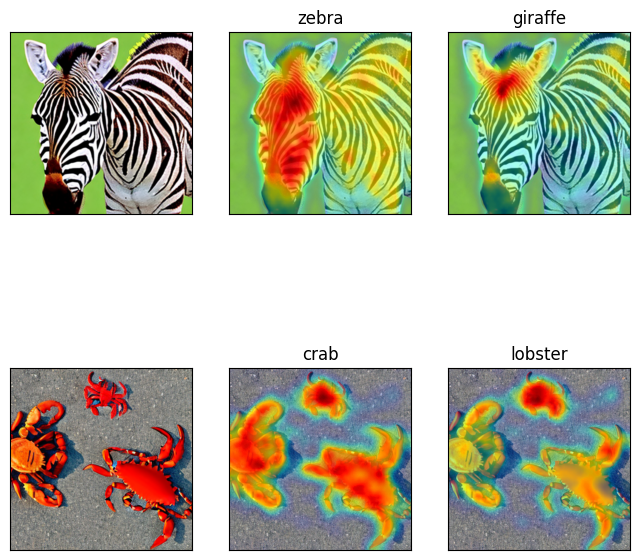

In [10]:
plt.rcParams['figure.figsize'] = (8, 8)
fig, ax = make_im_subplots(2, 3)

with daam.trace(model, save_heads=True) as trc:
  im1 = model('a zebra and a giraffe', num_inference_steps=20).images[0]
  heat_map = trc.compute_global_heat_map()
  zebra_map = heat_map.compute_word_heat_map('zebra')
  giraffe_map = heat_map.compute_word_heat_map('giraffe')

with daam.trace(model, save_heads=True) as trc:
  im2 = model('a crab and a lobster', num_inference_steps=20).images[0]
  heat_map = trc.compute_global_heat_map()
  crab_map = heat_map.compute_word_heat_map('crab')
  lobster_map = heat_map.compute_word_heat_map('lobster')

ax[0, 0].imshow(im1)
ax[1, 0].imshow(im2)
zebra_map.plot_overlay(im1, ax=ax[0, 1])
giraffe_map.plot_overlay(im1, ax=ax[0, 2])

crab_map.plot_overlay(im2, ax=ax[1, 1])
lobster_map.plot_overlay(im2, ax=ax[1, 2])

plt.show()